In [1]:
import os
import numpy as np
import seaborn as sns # for plots
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy import stats as sps # to calcualte confidence intervals, etc
from adjustText import adjust_text # to adjust the text labels in the plots (pip install adjustText)

from statsmodels.stats.anova import AnovaRM # perform F test

In [5]:
# setting directories
base_dir = '/Volumes/diedrichsen_data$/data/FunctionalFusion'
if not Path(base_dir).exists():
    base_dir = '/srv/diedrichsen/data/FunctionalFusion'
if not Path(base_dir).exists():
    base_dir = '/cifs/diedrichsen/data/FunctionalFusion'
atlas_dir = base_dir + '/Atlases'

language_dir = '/srv/diedrichsen/data/Cerebellum/Language'
if not Path(language_dir).exists():
    language_dir = '/cifs/diedrichsen/data/Cerebellum/Language'
if not Path(language_dir).exists:
    language_dir = '/Volumes/diedrichsen_data$/data/Cerebellum/Language'

In [3]:
# Functions
# prepare dataframe for plotting
def prep_df(dataframe, agg_kw = {}, groupby = "cond_name"):
    """
    prepare the region dataframe to do the scatter plot
    gets the mean across subjects (data point) and std of residuals
    Args:
        dataframe (pd.DataFrame) - dataframe with residuals info 
        agg_kw (dict) - dictionary determining info for dataframe aggregation

    Returns:
    g_df (pd.DataFrame) - dataframe ready for putting into the scatterplot function
    """
    # group by condition
    grouped = dataframe.groupby([groupby])
    g_df = grouped.agg(agg_kw)
    
    g_std = grouped.std(numeric_only=True)
    g_df["Y_CI"] = grouped.Y.apply(sps.sem) * 1.96
    g_df["X_CI"] = grouped.X.apply(sps.sem)*1.96
    g_df['err'] = g_std['res']
    
    return g_df


# plotting:
def make_plot(dataframe, hue = "cond_name", style = "cond_name", height = 4, aspect = 1):
    """
    make scatterplot
    uses FacetGrid 
    Args: 
    dataframe (pd.DataFrame) - output from prep_df
    hue (str)      - column name to be used to determine color
    style (str)    - column name to be used to determine shape of the marker
    label (str)    - column name to be used to determine the label of the data points
    height (int)   - int to determine the height of the plot
    aspect (float) - floating number to determine the aspect ratio of the plot
    """
    g = sns.FacetGrid(dataframe,  height=height, aspect=aspect)
    # do the scatter plot
    g.map_dataframe(sns.scatterplot, x="X", y="Y", 
                                    style = style, hue = hue, s = 50)
    g.add_legend()

    # fit the regression on top of the scatterplot
    g.map_dataframe(sns.regplot, x="X", y="Y", 
                        fit_reg=True, 
                        scatter_kws={"s": 0}, # size is set to 0 so that it doesn't cover the markers created in the scatterplot step 
                        line_kws={'label':"Linear Reg", "color": 'grey'})

    # put the errorbars in 
    g.map(plt.errorbar, x = df_preped['X'], 
                        y = df_preped['Y'], 
                        yerr = df_preped['err'],
                        elinewidth=1, 
                        fmt='none', # no marker will be used when plotting the error bars
                        color='grey', 
                        ecolor='0.9'
                )
    # set labels
    g.set_xlabels('Cortical Activation (a.u.)')
    g.set_ylabels('Cerebellar Activation (a.u.)')


In [8]:
# load the dataframe for the whole 
df_path = os.path.join(language_dir, "MDTB", "whole_ses-s2.tsv")
df = pd.read_csv(df_path, sep="\t")

conditions_df = df[df['cond_name'].isin(['PredictViol','Prediction','PredictScram'])]


df_averaged = conditions_df.groupby(['sn', 'cond_name']).mean()
df_averaged = df_averaged.drop(columns=['half','res','coef','R2'])
df_averaged = df_averaged.reset_index()
print(df_averaged)


        sn     cond_name  Unnamed: 0.2  index  Unnamed: 0.1  run  instruction  \
0   sub-02  PredictScram           3.0    5.0           5.0  1.0          0.0   
1   sub-02   PredictViol           2.0    4.0           4.0  1.0          0.0   
2   sub-02    Prediction           1.0    3.0           3.0  1.0          0.0   
3   sub-03  PredictScram           3.0    5.0           5.0  1.0          0.0   
4   sub-03   PredictViol           2.0    4.0           4.0  1.0          0.0   
..     ...           ...           ...    ...           ...  ...          ...   
67  sub-30   PredictViol           2.0    4.0           4.0  1.0          0.0   
68  sub-30    Prediction           1.0    3.0           3.0  1.0          0.0   
69  sub-31  PredictScram           3.0    5.0           5.0  1.0          0.0   
70  sub-31   PredictViol           2.0    4.0           4.0  1.0          0.0   
71  sub-31    Prediction           1.0    3.0           3.0  1.0          0.0   

    task_num  cond_num  reg

/tmp/ipykernel_59510/1749602021.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_averaged = conditions_df.groupby(['sn', 'cond_name']).mean()


/tmp/ipykernel_59510/3647883168.py:11: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in sn_groups:


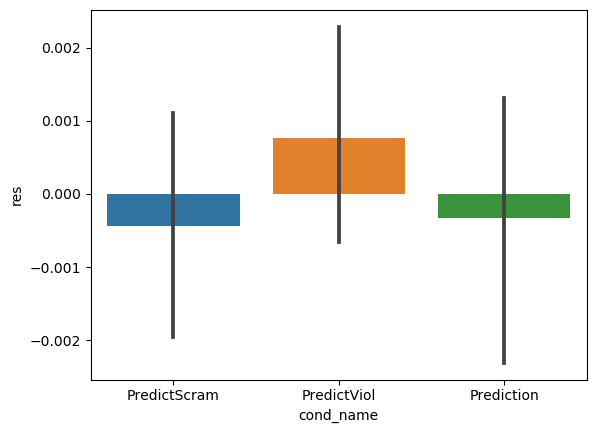

In [9]:
df_residuals = df_averaged.copy()

#create new columns to store the slope and intercept
df_residuals['slope'] = np.nan
df_residuals['intercept'] = np.nan

#group the dataframe by sn
sn_groups = df_residuals.groupby(['sn'])

#calculate slope and intercept for each subject
for name, group in sn_groups:
    # fit linear reg model
    slope, intercept = np.polyfit(group['X'], group['Y'], 1)
    # save values
    df_residuals.loc[df_residuals['sn'] == name, 'slope'] = slope
    df_residuals.loc[df_residuals['sn'] == name, 'intercept'] = intercept

# calcualte each res
for index, row in df_residuals.iterrows():

    Y_pred = row['slope'] * row['X'] + row['intercept']

    res = row['Y'] - Y_pred

    df_residuals.loc[index, 'Y_pred'] = Y_pred
    df_residuals.loc[index, 'res'] = res

sns.barplot(data=df_residuals,x='cond_name',y='res')

In [10]:
# prepare df for plotting
# by setting non-numeric fields to 'first', we make sure that they are not removed from the final dataframe
agg_kw= {'cond_name': 'first', 'X': np.mean, 'Y': np.mean, 'res': np.mean}
df_preped = prep_df(df_residuals ,groupby = "cond_name", agg_kw=agg_kw)

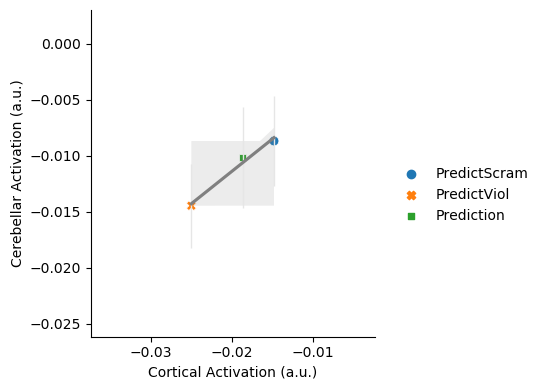

In [11]:
make_plot(df_preped, hue = "cond_name", style = "cond_name", height = 4, aspect = 1)

In [12]:
print(AnovaRM(data=df_residuals, depvar='res',
              subject='sn', within=['cond_name'], aggregate_func = np.mean).fit())

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
cond_name  0.4251 2.0000 46.0000 0.6562

